# Human-in-the-loop Breakpoints

- streams & user input injection

## Approval

User case.

what we need:

- a way to stop the execution
- a way to resume the execution

## Redefine financial advicer graph (from 03_agent.ipynb)

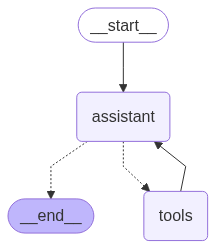

In [3]:
import requests
import yfinance as yf
from pprint import pformat
from langchain_core.tools import Tool
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState, START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


# Defining Tools
##################################################################################

def lookup_stock_symbol(company_name: str) -> str:
    """
    Converts a company name to its stock symbol using a financial API.

    Parameters:
        company_name (str): The full company name (e.g., 'Tesla').

    Returns:
        str: The stock symbol (e.g., 'TSLA') or an error message.
    """
    api_url = "https://www.alphavantage.co/query"
    params = {
        "function": "SYMBOL_SEARCH",
        "keywords": company_name,
        "apikey": "your_alphavantage_api_key"
    }
    
    response = requests.get(api_url, params=params)
    data = response.json()
    
    if "bestMatches" in data and data["bestMatches"]:
        return data["bestMatches"][0]["1. symbol"]
    else:
        return f"Symbol not found for {company_name}."


def fetch_stock_data_raw(stock_symbol: str) -> dict:
    """
    Fetches comprehensive stock data for a given symbol and returns it as a combined dictionary.

    Parameters:
        stock_symbol (str): The stock ticker symbol (e.g., 'TSLA').
        period (str): The period to analyze (e.g., '1mo', '3mo', '1y').

    Returns:
        dict: A dictionary combining general stock info and historical market data.
    """
    period = "1mo"
    try:
        stock = yf.Ticker(stock_symbol)

        # Retrieve general stock info and historical market data
        stock_info = stock.info  # Basic company and stock data
        stock_history = stock.history(period=period).to_dict()  # Historical OHLCV data

        # Combine both into a single dictionary
        combined_data = {
            "stock_symbol": stock_symbol,
            "info": stock_info,
            "history": stock_history
        }

        return pformat(combined_data)

    except Exception as e:
        return {"error": f"Error fetching stock data for {stock_symbol}: {str(e)}"}


# Binding tools to the LLM
##################################################################################

# Create tool bindings with additional attributes
lookup_stock = Tool.from_function(
    func=lookup_stock_symbol,
    name="lookup_stock_symbol",
    description="Converts a company name to its stock symbol using a financial API.",
    return_direct=False  # Return result to be processed by LLM
)

fetch_stock = Tool.from_function(
    func=fetch_stock_data_raw,
    name="fetch_stock_data_raw",
    description="Fetches comprehensive stock data including general info and historical market data for a given stock symbol.",
    return_direct=False
)

toolbox = [lookup_stock, fetch_stock]

# OPENAI_API_KEY environment variable must be set
simple_llm = ChatOpenAI(model="gpt-4o-mini")
llm_with_tools = simple_llm.bind_tools(toolbox)


# Defining Agent's node
##################################################################################

# System message
assistant_system_message = SystemMessage(content=("""
You are a professional financial assistant specializing in stock market analysis and investment strategies. 
Your role is to analyze stock data and provide **clear, decisive recommendations** that users can act on, 
whether they already hold the stock or are considering investing.

You have access to a set of tools that can provide the data you need to analyze stocks effectively. 
Use these tools to gather relevant information such as stock symbols, current prices, historical trends, 
and key financial indicators. Your goal is to leverage these resources efficiently to generate accurate, 
actionable insights for the user.

Your responses should be:
- **Concise and direct**, summarizing only the most critical insights.
- **Actionable**, offering clear guidance on whether to buy, sell, hold, or wait for better opportunities.
- **Context-aware**, considering both current holders and potential investors.
- **Free of speculation**, relying solely on factual data and trends.

### Response Format:
1. **Recommendation:** Buy, Sell, Hold, or Wait.
2. **Key Insights:** Highlight critical trends and market factors that influence the decision.
3. **Suggested Next Steps:** What the user should do based on their current position.

If the user does not specify whether they own the stock, provide recommendations for both potential buyers and current holders. Ensure your advice considers valuation, trends, and market sentiment.

Your goal is to help users make informed financial decisions quickly and confidently.
"""))

# Node
def assistant(state: MessagesState):
   return {"messages": [llm_with_tools.invoke([assistant_system_message] + state["messages"])]}


# Defining Graph
##################################################################################
# Graph
builder = StateGraph(MessagesState)

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(toolbox))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "assistant")

memory = MemorySaver()
graph = builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

## Adding a breakpoint to the graph

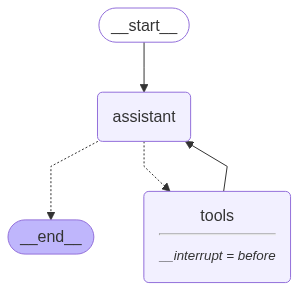

In [4]:
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Let's test the breakpoint

In [5]:
# start a new conversation
thread = {"configurable": {"thread_id": "1"}}

# define intiial user request
initial_input = {"messages": HumanMessage(content="Should I invest in Tesla stocks?")}

# run the graph and stream in values mode
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Should I invest in Tesla stocks?
================================== Ai Message ==================================
Tool Calls:
  lookup_stock_symbol (call_pDg3s5RTEmr3jE9xZa5apJ8r)
 Call ID: call_pDg3s5RTEmr3jE9xZa5apJ8r
  Args:
    __arg1: Tesla


## Check the graph current state

In [6]:
state = graph.get_state(thread)
state

StateSnapshot(values={'messages': [HumanMessage(content='Should I invest in Tesla stocks?', additional_kwargs={}, response_metadata={}, id='ad2412af-c463-4ae7-99ba-4d29ca3a52ee'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_pDg3s5RTEmr3jE9xZa5apJ8r', 'function': {'arguments': '{"__arg1":"Tesla"}', 'name': 'lookup_stock_symbol'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 392, 'total_tokens': 409, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C4tgtyA3P1CXh1DGD4UKbDxJs64Mh', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--2f89b774-a195-4ec7-8874-87c6be0ebd46-0', tool_calls=[{'name': 'lookup_stock_symbol

## Get the next node in the graph

In [7]:
state.next

('tools',)

## Resuming execution

### 1) Initializes a new execution flow based on the provided initial_input

```python
graph.stream(initial_input, thread, stream_mode="values")
```

### 2) resumes from the latest checkpoint stored in the thread state

```python
graph.stream(None, thread, stream_mode="values")
```

Passing `None` as initial_input tells LangGraph: “Continue execution from where it left off for the given `thread_id`.”

By setting initial_input = `None`, you’re not reinitializing the graph but rather instructing it to continue from the last recorded execution point for the given `thread_id`. This mechanism ensures smooth, stateful interactions, making cyclic approvals and multi-step workflows possible.

In [8]:
# as a first event LangGraph re-emits the current state (AIMessage with the tool call).
for event in graph.stream(None, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  lookup_stock_symbol (call_pDg3s5RTEmr3jE9xZa5apJ8r)
 Call ID: call_pDg3s5RTEmr3jE9xZa5apJ8r
  Args:
    __arg1: Tesla
================================= Tool Message =================================
Name: lookup_stock_symbol

TSLA
================================== Ai Message ==================================
Tool Calls:
  fetch_stock_data_raw (call_CSulFS4R3bNna9au8OVImMtx)
 Call ID: call_CSulFS4R3bNna9au8OVImMtx
  Args:
    __arg1: TSLA


## Combining all together

In [16]:
# Start a new conversation
thread = {"configurable": {"thread_id": "4"}}

initial_input = {"messages": HumanMessage(content="Should I invest in Tesla stocks?")}

current_state_reemit = False

# Run the graph in a loop, pausing at each tool-node call
while True:
    should_restart = False  # Reset flag at the start of each while-loop iteration

    # Run the graph until the next interruption (breakpoint before tool-node)
    for event in graph.stream(initial_input, thread, stream_mode="values"):
        event['messages'][-1].pretty_print()
        
        # Check if a tool is about to be called
        if "tool_calls" in event['messages'][-1].additional_kwargs:
            if  current_state_reemit:
                current_state_reemit = False
                continue

            else:
                tool_name = event['messages'][-1].additional_kwargs["tool_calls"][0]["function"]["name"]  # Extract the tool name
                # Get user feedback
                user_approval = input(f"Do you want to call the tool {tool_name}? (yes/no): ")

                if user_approval.lower() == "yes":
                    initial_input = None
                    current_state_reemit = True
                    should_restart = True
                else:
                    print(f"\n\nTool call {tool_name} was cancelled by user")

                break

    if should_restart:
        continue
    
    # Once the graph completes without hitting a tool node, break out of the loop
    break

================================ Human Message =================================

Should I invest in Tesla stocks?
================================== Ai Message ==================================
Tool Calls:
  lookup_stock_symbol (call_YAQl97BiGdpCDa08y5zRqakb)
 Call ID: call_YAQl97BiGdpCDa08y5zRqakb
  Args:
    __arg1: Tesla


Do you want to call the tool lookup_stock_symbol? (yes/no):  yes


================================== Ai Message ==================================
Tool Calls:
  lookup_stock_symbol (call_YAQl97BiGdpCDa08y5zRqakb)
 Call ID: call_YAQl97BiGdpCDa08y5zRqakb
  Args:
    __arg1: Tesla
================================= Tool Message =================================
Name: lookup_stock_symbol

TSLA
================================== Ai Message ==================================
Tool Calls:
  fetch_stock_data_raw (call_bRcbBwzA4JQg5GUoKIX3932T)
 Call ID: call_bRcbBwzA4JQg5GUoKIX3932T
  Args:
    __arg1: TSLA


Do you want to call the tool fetch_stock_data_raw? (yes/no):  yes


================================== Ai Message ==================================
Tool Calls:
  fetch_stock_data_raw (call_bRcbBwzA4JQg5GUoKIX3932T)
 Call ID: call_bRcbBwzA4JQg5GUoKIX3932T
  Args:
    __arg1: TSLA
================================= Tool Message =================================
Name: fetch_stock_data_raw

{'history': {'Close': {Timestamp('2025-07-15 00:00:00-0400', tz='America/New_York'): 310.7799987792969,
                       Timestamp('2025-07-16 00:00:00-0400', tz='America/New_York'): 321.6700134277344,
                       Timestamp('2025-07-17 00:00:00-0400', tz='America/New_York'): 319.4100036621094,
                       Timestamp('2025-07-18 00:00:00-0400', tz='America/New_York'): 329.6499938964844,
                       Timestamp('2025-07-21 00:00:00-0400', tz='America/New_York'): 328.489990234375,
                       Timestamp('2025-07-22 00:00:00-0400', tz='America/New_York'): 332.1099853515625,
                       Timestamp('2025-07-23 00:00:00-0

## Breakpoints in LangGraph API

In [11]:
from langgraph_sdk import get_client

URL = "http://127.0.0.1:2024" 
client = get_client(url=URL)

assistants = await client.assistants.search()
assistants

[{'assistant_id': '45d7f46b-abb2-5734-9fb9-b1edc76c6546',
  'graph_id': 'dev_mentor',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'dev_mentor',
  'created_at': '2025-08-15T17:20:59.259433+00:00',
  'updated_at': '2025-08-15T17:20:59.259433+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': 'ae2c32e4-0e45-57db-b449-103064dcb967',
  'graph_id': 'directive_memory_bot',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'directive_memory_bot',
  'created_at': '2025-08-15T17:20:59.156435+00:00',
  'updated_at': '2025-08-15T17:20:59.156435+00:00',
  'version': 1,
  'description': None},
 {'assistant_id': '89e77aa6-c452-5416-bd83-721b80077ae5',
  'graph_id': 'chatbot_long_term_memory',
  'config': {},
  'context': {},
  'metadata': {'created_by': 'system'},
  'name': 'chatbot_long_term_memory',
  'created_at': '2025-08-15T17:20:59.046553+00:00',
  'updated_at': '2025-08-15T17:20:59.046553+00:00',
  'version'

In [12]:
from langchain_core.messages import convert_to_messages

thread = await client.threads.create()
input_message = HumanMessage(content="Should I invest in Tesla stocks?")

async for event in client.runs.stream(
            thread["thread_id"], 
            assistant_id="b7480eb0-6390-53a5-9bc4-29bf27cbd1c4", 
            input={"messages": [input_message]}, 
            stream_mode="values",
            interrupt_before=["tools"],
):
    messages = event.data.get('messages', None)
    if messages:
        print(convert_to_messages(messages)[-1])

content='Should I invest in Tesla stocks?' additional_kwargs={} response_metadata={} id='4f963474-bd24-44da-b6b4-455f508e76cc'
content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 392, 'output_tokens': 17, 'total_tokens': 409, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'tool_calls': [{'id': 'call_GV3569VTHwvmK77fa9etaiUZ', 'function': {'arguments': '{"__arg1":"Tesla"}', 'name': 'lookup_stock_symbol'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 392, 'total_tokens': 409, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C4thSrxrdhtdBP3sCOm0lsdmfsXmh', 'service_tier': 

In [13]:
async for event in client.runs.stream(
            thread["thread_id"], 
            assistant_id="b7480eb0-6390-53a5-9bc4-29bf27cbd1c4", 
            input=None, 
            stream_mode="values",
            interrupt_before=["tools"],
):
    messages = event.data.get('messages', None)
    if messages:
        print(convert_to_messages(messages)[-1])

content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 392, 'output_tokens': 17, 'total_tokens': 409, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'tool_calls': [{'id': 'call_GV3569VTHwvmK77fa9etaiUZ', 'function': {'arguments': '{"__arg1":"Tesla"}', 'name': 'lookup_stock_symbol'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 17, 'prompt_tokens': 392, 'total_tokens': 409, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C4thSrxrdhtdBP3sCOm0lsdmfsXmh', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--c8bba95c-c8e1-400d-97e3-d5c8b376d406-0' tool_calls=[{'name

In [14]:
async for event in client.runs.stream(
            thread["thread_id"], 
            assistant_id="b7480eb0-6390-53a5-9bc4-29bf27cbd1c4", 
            input=None, 
            stream_mode="values",
            interrupt_before=["tools"],
):
    messages = event.data.get('messages', None)
    if messages:
        print(convert_to_messages(messages)[-1])

content='' additional_kwargs={'invalid_tool_calls': [], 'usage_metadata': {'input_tokens': 420, 'output_tokens': 19, 'total_tokens': 439, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}}, 'tool_calls': [{'id': 'call_OPPyjGaIBtrZm7oIuenMG3wg', 'function': {'arguments': '{"__arg1":"TSLA"}', 'name': 'fetch_stock_data_raw'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 19, 'prompt_tokens': 420, 'total_tokens': 439, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_560af6e559', 'id': 'chatcmpl-C4thaFqmXSm9FdiRB8piZXPGqsWPb', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None} id='run--e9054a2a-e311-49f4-81fb-5d3fd226b733-0' tool_calls=[{'name

AttributeError: 'NoneType' object has no attribute 'get'

## Breakpoints in Langgraph Studio

Let's copy/paste `financial_advisor` but with `interrupt_before=["tools"]`. (`studio/financial_advisor.py` -> `studio/financial_advisor_breakpoint.py`)